Epoch [1/5], Loss: 0.0535
Epoch [2/5], Loss: 0.0192
Epoch [3/5], Loss: 0.0014
Epoch [4/5], Loss: 0.0008
Epoch [5/5], Loss: 0.0008


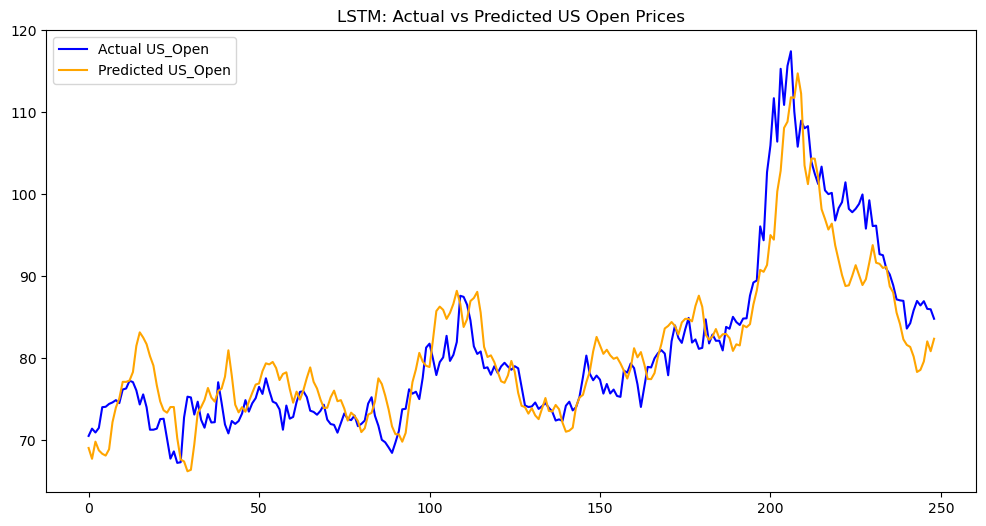

Mean Squared Error: 19.0620


In [2]:
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

# Load data
df = pd.read_csv('pca_stock_data.csv')

# Features and target
X = df.drop(columns=['US_Open'])
y = df['US_Open']

# Scale features and target using MinMaxScaler fitted only on training data
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# Scale the whole dataset (fitting on training only)
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

# Sequential train-test split: first 80% for training, rest for testing
train_size = int(0.8 * len(X))
X_train_scaled = X_scaled[:train_size]
X_test_scaled = X_scaled[train_size:]
y_train_scaled = y_scaled[:train_size]
y_test_scaled = y_scaled[train_size:]

# Create sequences for LSTM
def create_sequences(data, target, timesteps):
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i:i+timesteps])
        y.append(target[i+timesteps])
    return np.array(X), np.array(y)

# Number of historical timesteps to consider
timesteps = 3  # Increased from 10 to 20 to capture more historical context

# Create sequences for train and test sets
X_train_lstm, y_train_lstm = create_sequences(X_train_scaled, y_train_scaled, timesteps)
X_test_lstm, y_test_lstm = create_sequences(X_test_scaled, y_test_scaled, timesteps)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_lstm, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_lstm, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_lstm, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_lstm, dtype=torch.float32)

# Create DataLoader for batch training
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Model parameters
input_size = X_train_tensor.shape[2]  # Number of features
hidden_size = 300                     # Increased number of LSTM units
num_layers = 4                        # Increased number of LSTM layers
output_size = 1                       # Single output (US_Open)
dropout = 0.2                         # Increased dropout rate to prevent overfitting

# Instantiate the model with Bidirectional LSTM
class LSTMWithAttention(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMWithAttention, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.attention = nn.Linear(hidden_size, 1)  # Learnable attention weights
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        # Compute attention weights
        attn_weights = torch.softmax(self.attention(out), dim=1)
        # Compute context vector
        context_vector = torch.sum(attn_weights * out, dim=1)
        # Final prediction
        return self.fc(context_vector)

model = LSTMWithAttention(input_size, hidden_size, num_layers, output_size, dropout)

# Loss function and optimizer
criterion = nn.SmoothL1Loss() #to handle outliers
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)  # Reduced learning rate for finer updates

# Early stopping parameters
early_stopping_patience = 10
best_loss = float('inf')
patience_counter = 0

# Training the model
num_epochs = 5  # Increased epochs to allow for more training
model.train()

for epoch in range(num_epochs):
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}")

    # Early stopping logic
    if avg_epoch_loss < best_loss:
        best_loss = avg_epoch_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered")
            break

# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    y_pred_rescaled = scaler_y.inverse_transform(y_pred.numpy())
    y_test_rescaled = scaler_y.inverse_transform(y_test_tensor.numpy())

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test_rescaled, label="Actual US_Open", color='blue')
plt.plot(y_pred_rescaled, label="Predicted US_Open", color='orange')
plt.legend()
plt.title("LSTM: Actual vs Predicted US Open Prices")
plt.show()

# Calculate evaluation metrics
mse = np.mean((y_test_rescaled - y_pred_rescaled)**2)
print(f"Mean Squared Error: {mse:.4f}")



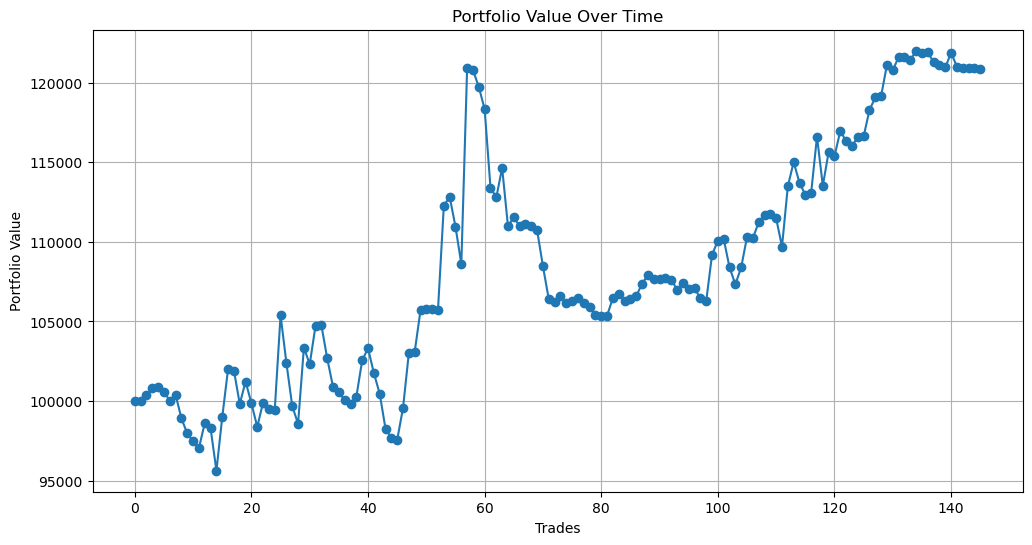

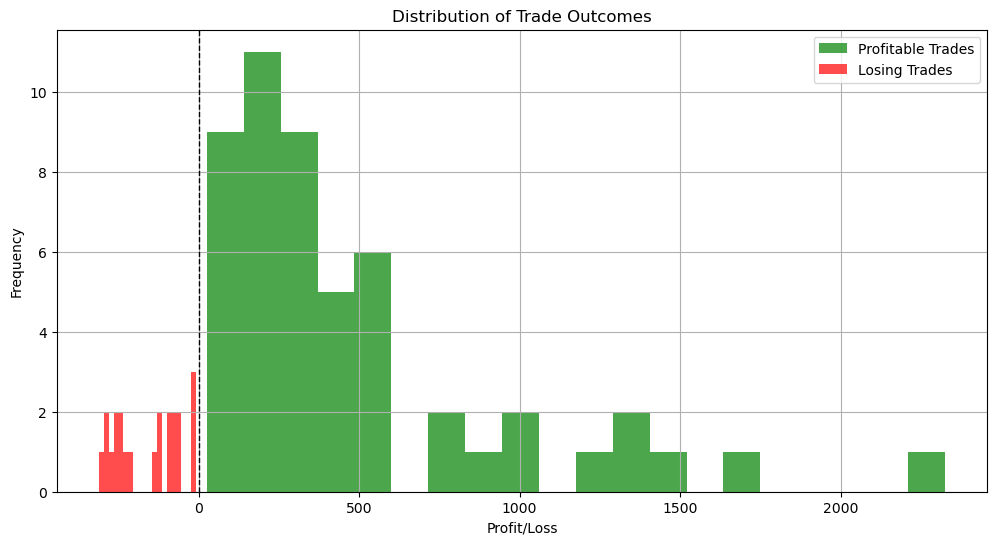


=== Performance Metrics ===
Total Profit: 21449.72
Total Trades: 73
Win Rate: 69.86%
----------------------------


=== Trading Performance Summary ===
Initial Cash: 100000.00
Final Portfolio Value: 120878.27
Portfolio Growth: 20.88%
Total Buys: 73, Total Sells: 73
-----------------------------------



In [3]:
import torch
import pandas as pd
import numpy as np
from TradingSimulator import TradingSimulator
import matplotlib.pyplot as plt

# Assuming LSTM model, data, and other imports are already available

# Model evaluation to generate predictions
# Evaluate the model
model.eval()

with torch.no_grad():
    y_pred = model(X_test_tensor)
    y_pred_rescaled = scaler_y.inverse_transform(y_pred.numpy().reshape(-1, 1))  # Rescale predictions
    y_test_rescaled = scaler_y.inverse_transform(y_test_tensor.numpy())           # Rescale actual values

# Adjust the indexing to match the test range and avoid out-of-bounds errors
start_idx = train_size + timesteps
end_idx = min(start_idx + len(y_pred_rescaled), len(df))

# Slice dataframe to match the range of predictions
df_test_with_signals = df.iloc[start_idx:end_idx].copy()

# Generate buy and immediate sell signals based on predicted US open price
# If the predicted US open price is greater than the current HK close price by a certain threshold (e.g., 0.5%), we generate a buy signal followed by an immediate sell signal
threshold = 0.001
signals = []

for i in range(len(df_test_with_signals)):
    hk_close_price = df_test_with_signals['HK_Close'].iloc[i]
    predicted_us_open_price = y_pred_rescaled[i][0]  # Use the rescaled prediction

    if predicted_us_open_price > hk_close_price * (1 + threshold):
        signals.append(1)  # Buy signal
    elif predicted_us_open_price < hk_close_price * (1 - threshold):
        signals.append(-1)  # Sell signal
    else:
        signals.append(0)  # Hold signal


# Append signals to the dataframe for trading simulator usage
df_test_with_signals['signal'] = signals

# Initialize the trading simulator
simulator = TradingSimulator(initial_cash=100000, transaction_fee=0.001)
simulator.run(df_test_with_signals, hk_close_column='HK_Close', us_open_column='US_Open', signal_column='signal')

# Plotting the portfolio growth
simulator.plot_portfolio_growth()

# Plotting trade outcomes
simulator.plot_trade_outcomes()

# Print metrics and summary
simulator.calculate_metrics()
simulator.summary(final_price=df_test_with_signals['US_Open'].iloc[-1])
